In [930]:
import sys                                                  # Read system parameters.
import numpy as np                                          # Work with multi-dimensional arrays.
import pandas as pd                                         # Manipulate and analyze data.
import matplotlib                                           # Create and format charts.
import matplotlib.pyplot as plt
import seaborn as sns                                       # Make charting easier.
import sklearn                                              # Train and evaluate machine learning models.
import category_encoders as ce
from sklearn.model_selection import train_test_split, \
                                    learning_curve, \
                                    GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, \
                                 ElasticNet
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, \
                            mean_absolute_error, \
                            mean_squared_error
from sklearn.dummy import DummyRegressor
import xgboost                                              # Build gradient boosting models.
from xgboost import XGBRegressor
import pickle                                               # Save Python objects as binary files.
import warnings                                             # Suppress warnings.
warnings.filterwarnings('ignore')

# Ensure results are reproducible.
np.random.seed(1)

# Set the style for all charts
plt.style.use('tableau-colorblind10')

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sns.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- XGBoost {}'.format(xgboost.__version__))

Libraries used in this project:
- Python 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
- NumPy 2.0.0
- pandas 2.2.2
- Matplotlib 3.9.1
- Seaborn 0.13.2
- scikit-learn 1.7.0
- XGBoost 3.0.2


In [931]:
# Extract the dataset
# The data from https://www.kaggle.com/datasets/mirichoi0218/insurance/data
data = pd.read_csv("insurance.csv")

# Exploratory Data Analysis

In [932]:
# Look at 5 first rows
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [933]:
# View the shape 
data.shape

(1338, 7)

In [934]:
# Check data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [935]:
# Check null values using isnull()
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [936]:
# Check duplicate rows
data[data.duplicated(keep = False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


We have 1 duplicated row we will deal with it in the transformation phase

In [937]:
# Distribution of the dataset
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [938]:
# Look at the distribution of the target variable
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

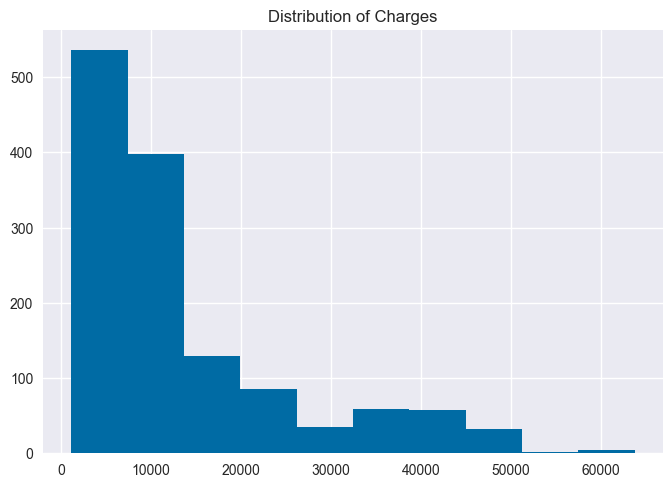

In [939]:
# Visualize the distribution of the target variable
data['charges'].hist()
plt.title("Distribution of Charges");

The traget feature is right skewed indicate there are outliers

In [940]:
# Look at the skewness of the numeric variables
data.skew(numeric_only=True)

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

This confirm the right skewed of the target and moderately skewed for the childern feature

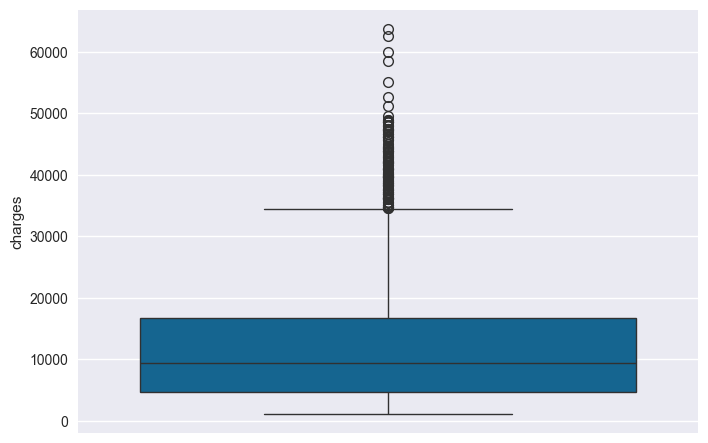

In [941]:
# Plot box plot to check outliers for the target feature
sns.boxplot(data['charges']);

This chart confirms that there are outliers

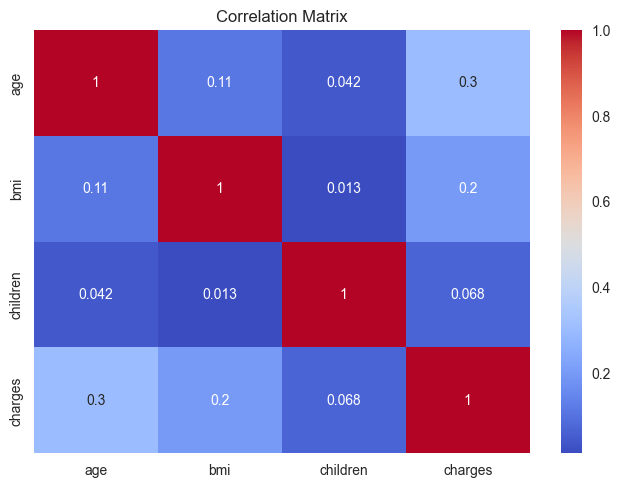

In [942]:
# Correlation between numeric variables
corr = data.corr(numeric_only=True).abs()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show();

The heatmap shows there is no strong corelation between numeric features

# Transformation Phase

In [943]:
# Remove duplicate rows
data_cleaned = data.drop_duplicates()

In [944]:
# Shape of data after drop duplicated rows
data_cleaned.shape

(1337, 7)

After remove duplicates the data now is less by one of the original data

In [945]:
# Encode category data
cols_to_be_encode = data.select_dtypes('object').columns
encoder = ce.OneHotEncoder(cols = cols_to_be_encode,
                          return_df = True,
                          use_cat_names = True)

data_encoded = encoder.fit_transform(data)
data_encoded

,age,sex_female,sex_male,bmi,children,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,charges
0,19,1,0,27.900,0,1,0,1,0,0,0,16884.92400
1,18,0,1,33.770,1,0,1,0,1,0,0,1725.55230
2,28,0,1,33.000,3,0,1,0,1,0,0,4449.46200
3,33,0,1,22.705,0,0,1,0,0,1,0,21984.47061
4,32,0,1,28.880,0,0,1,0,0,1,0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,0,1,30.970,3,0,1,0,0,1,0,10600.54830
1334,18,1,0,31.920,0,0,1,0,0,0,1,2205.98080
1335,18,1,0,36.850,0,0,1,0,1,0,0,1629.83350
1336,21,1,0,25.800,0,0,1,1,0,0,0,2007.94500


In [946]:
# Check data types changes
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex_female        1338 non-null   int64  
 2   sex_male          1338 non-null   int64  
 3   bmi               1338 non-null   float64
 4   children          1338 non-null   int64  
 5   smoker_yes        1338 non-null   int64  
 6   smoker_no         1338 non-null   int64  
 7   region_southwest  1338 non-null   int64  
 8   region_southeast  1338 non-null   int64  
 9   region_northwest  1338 non-null   int64  
 10  region_northeast  1338 non-null   int64  
 11  charges           1338 non-null   float64
dtypes: float64(2), int64(10)
memory usage: 125.6 KB


In [947]:
# Distribution of the data
data_encoded.describe()

,age,sex_female,sex_male,bmi,children,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,0.505232,30.663397,1.094918,0.204783,0.795217,0.242900,0.272048,0.242900,0.242152,13270.422265
std,14.049960,0.500160,0.500160,6.098187,1.205493,0.403694,0.403694,0.428995,0.445181,0.428995,0.428546,12110.011237
min,18.000000,0.000000,0.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,0.000000,26.296250,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4740.287150
50%,39.000000,0.000000,1.000000,30.400000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9382.033000
75%,51.000000,1.000000,1.000000,34.693750,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,16639.912515
max,64.000000,1.000000,1.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63770.428010


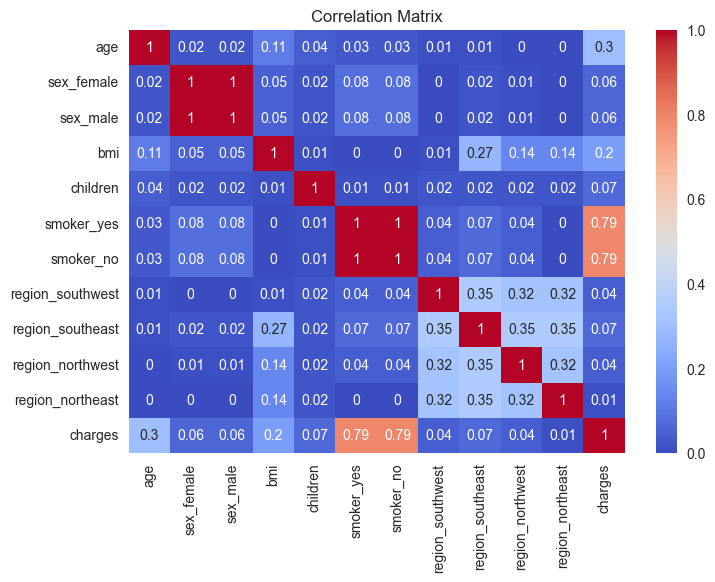

In [948]:
# Correlation after encoding
corr = data_encoded.corr(numeric_only=True).abs().round(2)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show();

After the encoding the matrix shows that sex(female and male) and smoker(yes and no) have strong correlation
so we need to drop some columns

In [949]:
# Drop columns with strong correlation
cols_to_drop = ['sex_female', 'smoker_no']

final_data = data_encoded.drop(cols_to_drop, axis=1)

# Review final data
final_data.head()

,age,sex_male,bmi,children,smoker_yes,region_southwest,region_southeast,region_northwest,region_northeast,charges
0,19,0,27.900,0,1,1,0,0,0,16884.92400
1,18,1,33.770,1,0,0,1,0,0,1725.55230
2,28,1,33.000,3,0,0,1,0,0,4449.46200
3,33,1,22.705,0,0,0,0,1,0,21984.47061
4,32,1,28.880,0,0,0,0,1,0,3866.85520


# Train Machine Learning Models

In [950]:
# Split the data for target label and features
target_data = final_data['charges']
features = final_data.drop(['charges'], axis = 1)

In [951]:
# Split the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target_data,
                                                    test_size= 0.3)

In [952]:
# Scale numeric features for linear regression models
# The Exception is children since it's values distrect
numerice_features = ['age', 'bmi']

scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numerice_features])

X_test_scaled_numeric = scaler.transform(X_test[numerice_features])

In [953]:
# Keep OneHotEncode columns as is
X_train_ohe = X_train.drop(numerice_features, axis=1).reset_index(drop=True)
X_test_ohe = X_test.drop(numerice_features, axis=1).reset_index(drop=True)

In [954]:
# Combine the results for training
X_train_scaled = pd.concat(
    [pd.DataFrame(X_train_scaled_numeric, columns=numerice_features), X_train_ohe], axis = 1
)

X_test_scaled = pd.concat(
    [pd.DataFrame(X_test_scaled_numeric, columns=numerice_features), X_test_ohe],  axis = 1
)

## Train Linear Regression Model

In [955]:
# Build the model and fitting
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [956]:
# Make predictions
linreg_y_pred = linreg.predict(X_test_scaled)

In [957]:
# 5 rows quick compare
results = pd.concat([y_test[:5], X_test[:5]], axis = 1)
results.insert(1, 'model_pred', linreg_y_pred[:5])
results               

,charges,model_pred,age,sex_male,bmi,children,smoker_yes,region_southwest,region_southeast,region_northwest,region_northeast
559,1646.4297,4610.315541,19,1,35.53,0,0,0,0,1,0
1087,11353.2276,12887.893880,57,1,31.54,0,0,0,0,1,0
1020,8798.5930,12573.948752,51,1,37.00,0,0,1,0,0,0
460,10381.4787,13197.836626,49,0,36.63,3,0,0,1,0,0
802,2103.0800,629.337182,21,1,22.30,1,0,1,0,0,0


In [958]:
# Obtain the model's score
linreg_score = r2_score(y_test, linreg_y_pred)
linreg_score

0.740598931692721

## Train Decision Tree Regressor Model

In [959]:
# Build the model and fitting
reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [960]:
# Make predictions
reg_tree_y_pred = reg_tree.predict(X_test)

In [961]:
# 5 rows quick compare
results['model_pred'] = reg_tree_y_pred[:5]
results

,charges,model_pred,age,sex_male,bmi,children,smoker_yes,region_southwest,region_southeast,region_northwest,region_northeast
559,1646.4297,1263.24900,19,1,35.53,0,0,0,0,1,0
1087,11353.2276,11842.62375,57,1,31.54,0,0,0,0,1,0
1020,8798.5930,8457.81800,51,1,37.00,0,0,1,0,0,0
460,10381.4787,10702.64240,49,0,36.63,3,0,0,1,0,0
802,2103.0800,1964.78000,21,1,22.30,1,0,1,0,0,0


In [962]:
# Obtain the model's score
reg_tree_score = r2_score(y_test, reg_tree_y_pred)
reg_tree_score

0.7286869061944496

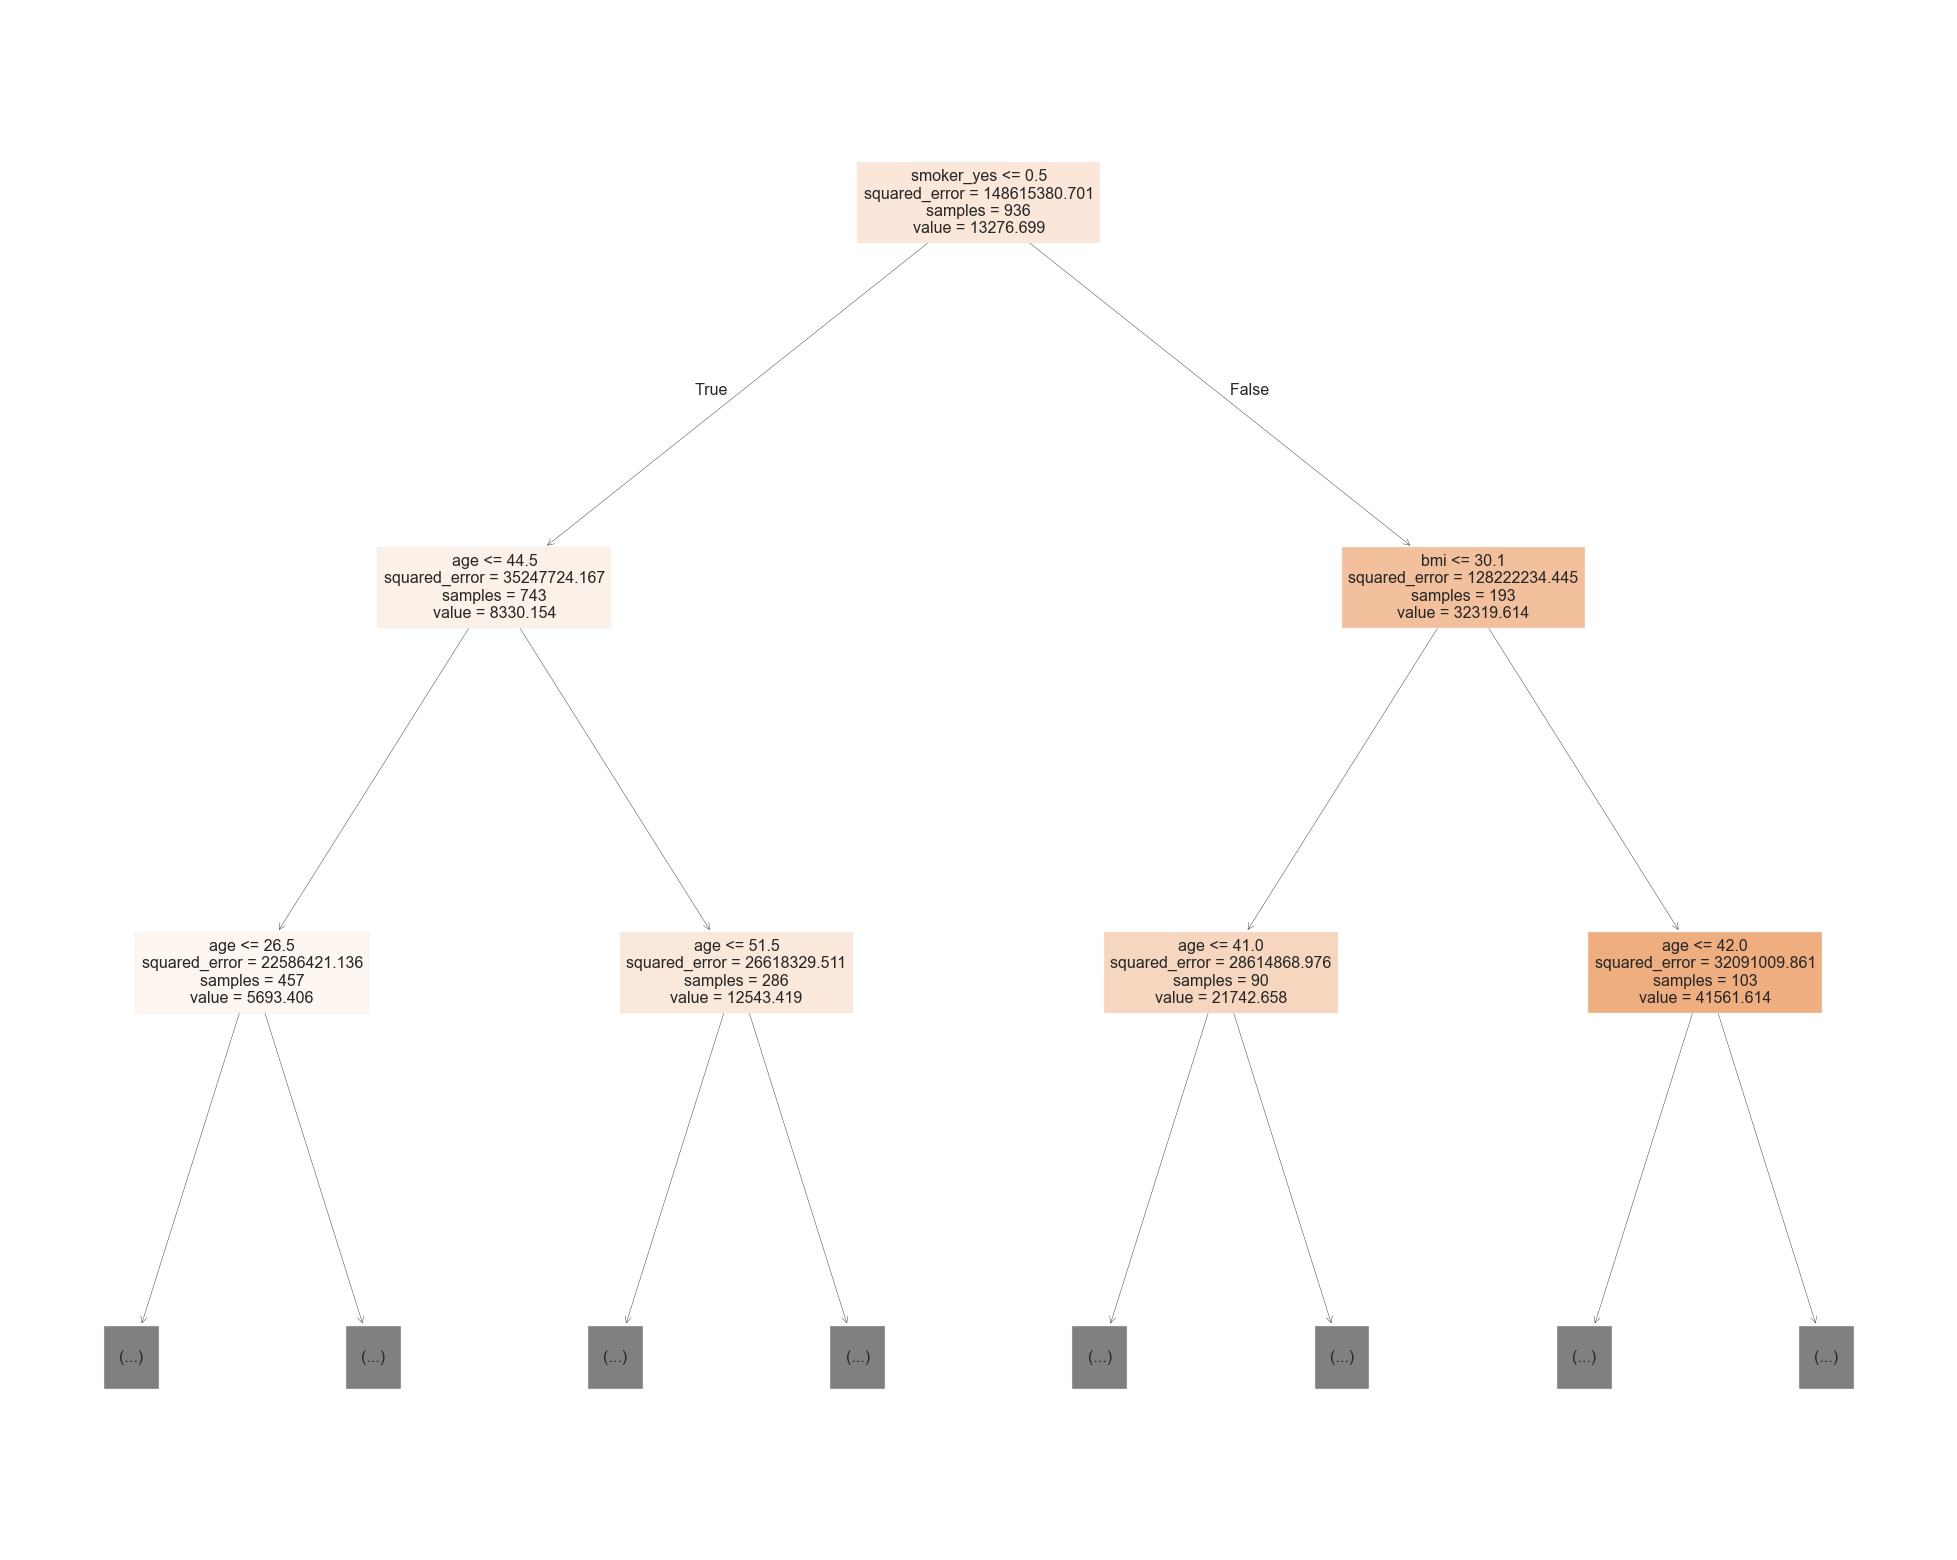

In [963]:
# Visualiza the decision tree
fig = plt.figure(figsize = (25, 20))
_ = tree.plot_tree(reg_tree,
                   feature_names = list(X_train.columns),
                   max_depth = 2,
                   filled = True)

## Train a Random Forest Model

In [964]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [965]:
rf_y_pred = rf.predict(X_test)

In [966]:
results['model_pred'] = rf_y_pred[:5]
results

,charges,model_pred,age,sex_male,bmi,children,smoker_yes,region_southwest,region_southeast,region_northwest,region_northeast
559,1646.4297,1665.172042,19,1,35.53,0,0,0,0,1,0
1087,11353.2276,12299.341677,57,1,31.54,0,0,0,0,1,0
1020,8798.5930,9025.917144,51,1,37.00,0,0,1,0,0,0
460,10381.4787,11178.355916,49,0,36.63,3,0,0,1,0,0
802,2103.0800,2208.756028,21,1,22.30,1,0,1,0,0,0


In [967]:
rf_score = r2_score(y_test, rf_y_pred)
rf_score

0.833523597172475

## Train a Gradient Boosting Regressor Model

In [968]:
xgb = XGBRegressor(objective = 'reg:squarederror', n_jobs = 1)
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [969]:
xgb_y_pred = xgb.predict(X_test)

In [970]:
results['model_pred'] = xgb_y_pred[:5]
results

,charges,model_pred,age,sex_male,bmi,children,smoker_yes,region_southwest,region_southeast,region_northwest,region_northeast
559,1646.4297,4864.185059,19,1,35.53,0,0,0,0,1,0
1087,11353.2276,10920.722656,57,1,31.54,0,0,0,0,1,0
1020,8798.5930,8886.980469,51,1,37.00,0,0,1,0,0,0
460,10381.4787,9593.602539,49,0,36.63,3,0,0,1,0,0
802,2103.0800,1235.120239,21,1,22.30,1,0,1,0,0,0


In [971]:
xgb_score = r2_score(y_test, xgb_y_pred)
xgb_score

0.8123932679130065

### Compare Models Score

In [972]:
r2_scores = [linreg_score, reg_tree_score, rf_score, xgb_score]

models = ["linreg", "reg_tree", "rf", "xgb"]

r2_scores_df = pd.DataFrame({"R2 Score": r2_scores}, index = models)
r2_scores_df

,R2 Score
linreg,0.740599
reg_tree,0.728687
rf,0.833524
xgb,0.812393


# Tuning Regression Models

In [973]:
# Define the parameter to be use to tune the linear regression model
param_grid = {'l1_ratio': [0.1, 0.5, 0.9],
              'alpha': [0.0001, 0.001, 0.01, 0.1],
              'max_iter': [100, 1000, 10000]}

print(param_grid)

{'l1_ratio': [0.1, 0.5, 0.9], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [100, 1000, 10000]}


In [974]:
# We will use ElasticNet() class which accept hyperparameters
# Build the model
model = ElasticNet()

# Using GridSearchCV to find best parameters
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = 1,
                  verbose = 2)

# Fit the model
gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...........alpha=0.0001, l1_ratio=0.1, max_iter=100; total time=   0.0s
[CV] END ...........alpha=0.0001, l1_ratio=0.1, max_iter=100; total time=   0.0s
[CV] END ...........alpha=0.0001, l1_ratio=0.1, max_iter=100; total time=   0.0s
[CV] END ...........alpha=0.0001, l1_ratio=0.1, max_iter=100; total time=   0.0s
[CV] END ...........alpha=0.0001, l1_ratio=0.1, max_iter=100; total time=   0.0s
[CV] END ..........alpha=0.0001, l1_ratio=0.1, max_iter=1000; total time=   0.0s
[CV] END ..........alpha=0.0001, l1_ratio=0.1, max_iter=1000; total time=   0.0s
[CV] END ..........alpha=0.0001, l1_ratio=0.1, max_iter=1000; total time=   0.0s
[CV] END ..........alpha=0.0001, l1_ratio=0.1, max_iter=1000; total time=   0.0s
[CV] END ..........alpha=0.0001, l1_ratio=0.1, max_iter=1000; total time=   0.0s
[CV] END .........alpha=0.0001, l1_ratio=0.1, max_iter=10000; total time=   0.0s
[CV] END .........alpha=0.0001, l1_ratio=0.1, m

,estimator,ElasticNet()
,param_grid,"{'alpha': [0.0001, 0.001, ...], 'l1_ratio': [0.1, 0.5, ...], 'max_iter': [100, 1000, ...]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [975]:
# Show best parameters and model score
print("Best R2 score:  ", round(gs.best_score_, 2))
print("Best parameters:", gs.best_params_)

Best R2 score:   0.75
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9, 'max_iter': 1000}


In [976]:
# Make prediction
elastic_y_pred = gs.predict(X_test_scaled)

In [977]:
# Print the score
linreg_tuned_score= r2_score(y_test, elastic_y_pred)
linreg_tuned_score

0.7407829705140223

In [978]:
# Define the parameters to be use to tune the decision tree regressor
param_grid = {'max_depth': [3, 5, 7],
              'min_samples_split': [10, 20, 30],
              'min_samples_leaf':[5, 10, 20]}

print(param_grid)

{'max_depth': [3, 5, 7], 'min_samples_split': [10, 20, 30], 'min_samples_leaf': [5, 10, 20]}


In [979]:
# Build the model
model = DecisionTreeRegressor()
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = 1,
                  verbose = 2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=20; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=5, min_samples_split=30; total time=   0.0s
[CV] END max_depth=3, min

,estimator,DecisionTreeRegressor()
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_leaf': [5, 10, ...], 'min_samples_split': [10, 20, ...]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [980]:
print("Best R2 score:  ", round(gs.best_score_, 2))
print("Best parameters:", gs.best_params_)

Best R2 score:   0.85
Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [981]:
# Make predictions
reg_tree_y_pred2 = gs.predict(X_test)

In [982]:
# Obtain model's score
reg_tree_tuned_score = r2_score(y_test, reg_tree_y_pred2)
reg_tree_tuned_score

0.850756927384472

In [983]:
# Define the parameters to tune the random forest regressor model
param_grid = {"n_estimators": [50, 100],
              "max_depth": [3, 5, None],
              "min_samples_split": [5, 10],
              "min_samples_leaf": [2, 4]}

print(param_grid)

{'n_estimators': [50, 100], 'max_depth': [3, 5, None], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 4]}


In [984]:
# Build the model
model = RandomForestRegressor()
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = 1,
                  verbose = 2)

# Fit the model
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, min_samples_leaf=2, m

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_leaf': [2, 4], 'min_samples_split': [5, 10], 'n_estimators': [50, 100]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [985]:
print("Best R2 score  :", round(gs.best_score_, 2))
print("Best paramters :", gs.best_params_)

Best R2 score  : 0.86
Best paramters : {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [986]:
# Make predictions
rf_y_pred2 = gs.predict(X_test)

In [987]:
# Obtain model's score
rf_tuned_score = r2_score(y_test, rf_y_pred2)
rf_tuned_score

0.8581132555181347

In [988]:
# Define the parameters for xgb regressor model
param_grid = {"n_estimators": [50, 100],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 5],
              "reg_alpha": [0, 0.1, 1],
              "reg_lambda": [0, 0.1, 1]}

print(param_grid)

{'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'reg_alpha': [0, 0.1, 1], 'reg_lambda': [0, 0.1, 1]}


In [989]:
# Build the model
model = XGBRegressor(objective = 'reg:squarederror', n_jobs = 1)
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = 1,
                  verbose = 2)

# Fit the model
gs.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.1; tota

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [50, 100], 'reg_alpha': [0, 0.1, ...], ...}"
,scoring,None
,n_jobs,1
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [990]:
print("Best R2 score  :", round(gs.best_score_, 2))
print("Best parameters:", gs.best_params_)

Best R2 score  : 0.86
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}


In [991]:
# Make predictions
xgb_y_pred2 = gs.predict(X_test)

In [992]:
# Obtain model's score
xgb_tuned_score = r2_score(y_test, xgb_y_pred2)
xgb_tuned_score

0.867263314098716

### Compare Tuned Models Score Plus The Previous Models

In [993]:
r2_scores = [linreg_score, linreg_tuned_score, reg_tree_score, reg_tree_tuned_score,
                 rf_score, rf_tuned_score, xgb_score, xgb_tuned_score]

models = ["linreg", "linreg_tuned", "reg_tree", "reg_tree_tuned", "rf", "rf_tuned", "xgb", "xgb_tuned"]

r2_scores_df = pd.DataFrame({"R2 Score": r2_scores}, index = models)
r2_scores_df

,R2 Score
linreg,0.740599
linreg_tuned,0.740783
reg_tree,0.728687
reg_tree_tuned,0.850757
rf,0.833524
rf_tuned,0.858113
xgb,0.812393
xgb_tuned,0.867263


<p>The tuned models performs better regard the R2 score</p>

# Evaluating Regression Models

In [994]:
# Evaluate tuned models to pick the best one based on MSE metric
# List of model names
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Dummy Regressor']

# List of metrics
metrics = ['R2', 'MAE', 'MSE', 'RMSE']

# List of model predictions
pred_list = ['elastic_y_pred', 'reg_tree_y_pred2', 'rf_y_pred2', 'xgb_y_pred2', 'dummy_y_pred']

# Build baseline model 
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_y_pred = dummy.predict(X_test)

# Empty array
scores = np.empty((0,4))

# Loop throgh every model to get scores
for i in pred_list:
    scores = np.append(scores,
                       np.array([[r2_score(y_test, globals()[i]),
                                  mean_absolute_error(y_test, globals()[i]),
                                  mean_squared_error(y_test, globals()[i]),
                                  np.sqrt(mean_squared_error(y_test, globals()[i]))]]),
                       axis=0)

# Round values
scores = np.around(scores, 2)

# Put the values into df
scoring_df = pd.DataFrame(scores, index = models, columns = metrics)
scoring_df.sort_values(by = 'MSE', ascending = True)

,R2,MAE,MSE,RMSE
XGBoost,0.87,2391.17,1.881100e+07,4337.17
Random Forest,0.86,2488.49,2.010772e+07,4484.16
Decision Tree,0.85,2563.21,2.115023e+07,4598.94
Linear Regression,0.74,4149.49,3.673537e+07,6060.97
Dummy Regressor,-0.00,8820.96,1.417171e+08,11904.50


<p>Based on MSE metrics the best model XGBoost.</p>

In [995]:
# Asssign best model to variable
best_model = gs.best_estimator_
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [996]:
# It's a good way to plot the results 
# Create new df for residuals
resid_df = pd.DataFrame()
resid_df['charges'] = y_test
resid_df['charges_pred'] = xgb_y_pred2
resid_df['residual'] = resid_df['charges'] - resid_df['charges_pred']
resid_df = resid_df.sort_values(by = 'charges')
resid_df['record_num'] = np.arange(len(resid_df))
resid_df.head()

,charges,charges_pred,residual,record_num
808,1131.5066,2907.14502,-1775.63842,0
663,1136.3994,2907.14502,-1770.74562,1
194,1137.4697,2907.14502,-1769.67532,2
866,1141.4451,2907.14502,-1765.69992,3
442,1149.3959,2555.00415,-1405.60825,4


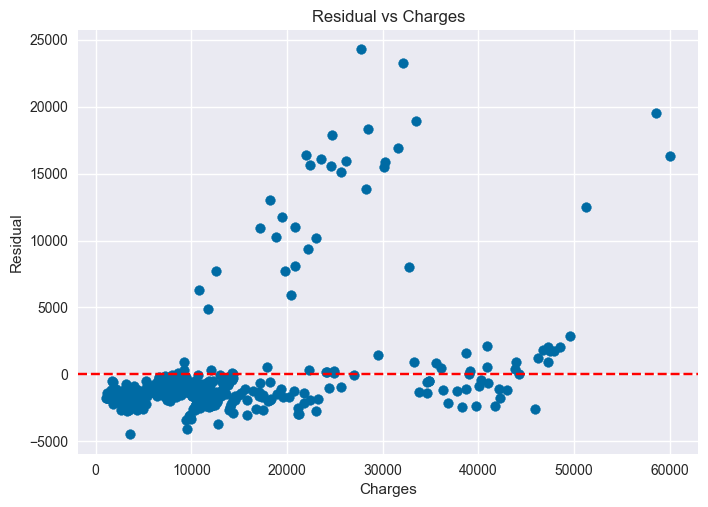

In [997]:
# Plot scatter chart
plt.scatter(resid_df['charges'], resid_df['residual'])
plt.axhline(y=0, color='r', linestyle='--')

plt.title("Residual vs Charges")
plt.xlabel("Charges")
plt.ylabel("Residual")
plt.show();

<p>We can notice that the error increase between 20K to 30k</p>

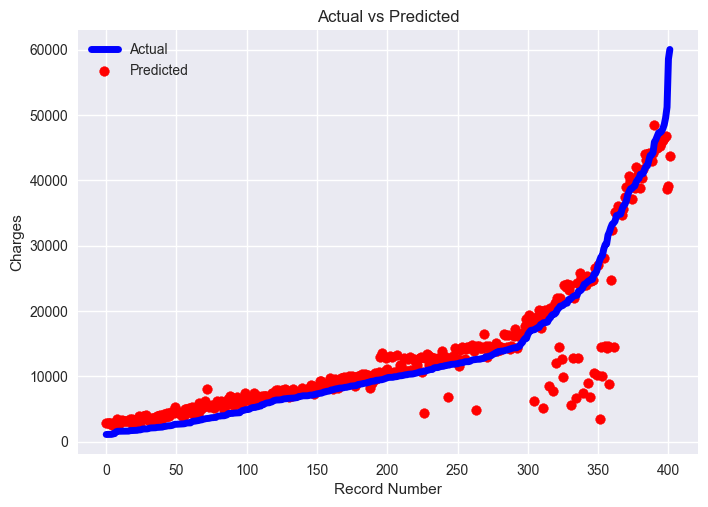

In [998]:
# Plot a line chart for the ground truth and scatter for predicted
plt.plot(resid_df['record_num'], resid_df['charges'], color = 'blue', linewidth = 5)
plt.scatter(resid_df['record_num'], resid_df['charges_pred'], color = 'red')

plt.legend(['Actual', 'Predicted'])
plt.title("Actual vs Predicted")
plt.ylabel('Charges')
plt.xlabel('Record Number')
plt.show();

### Generate a Feature Importance Plot

In [999]:
def feature_importance_plot(model, X_train, n):
    """Plot feature importance. Only works for ensemble learning."""
    feature_importances = pd.Series(model.feature_importances_, index = X_train.columns)

    feature_importances.nlargest(n).plot(kind = 'barh')
    plt.title(f"Top {n} Features")
    plt.show();

<p>This function will help to identify which features are most important to the model</p>

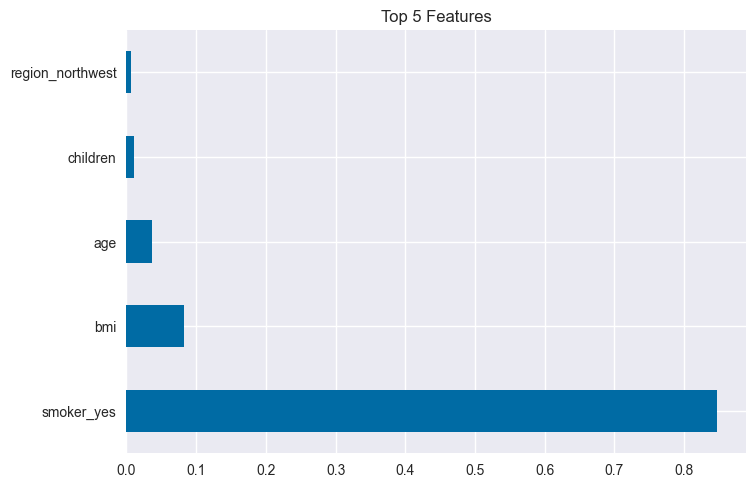

In [1000]:
# Call the function to plot 5 feature that are important
feature_importance_plot(best_model, X_train, 5)

<p>We can identify the smoker_yes feature has the most significant important</p>

### Generate Plot Learning Curve

In [1001]:
def plot_learning_curves(model, X_train, y_train):
    """Plots learning curves for model validation."""
    train_sizes, train_scores, test_scores = \
    learning_curve(model, X_train, y_train, cv = 5,
                   scoring = 'neg_mean_squared_error',
                   n_jobs = 1,
                   shuffle = True,
                   train_sizes = np.linspace(0.01, 1.0, 5))

    # Means of training and test set scores.
    train_mean = np.mean(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--',
             color = 'blue', label = 'Training score')
    plt.plot(train_sizes, test_mean, 
             color = 'blue', label = 'Cross-validation score')

    # Create plot.
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Negative MSE')
    plt.legend(loc = 'best')
    plt.tight_layout()

    plt.show();

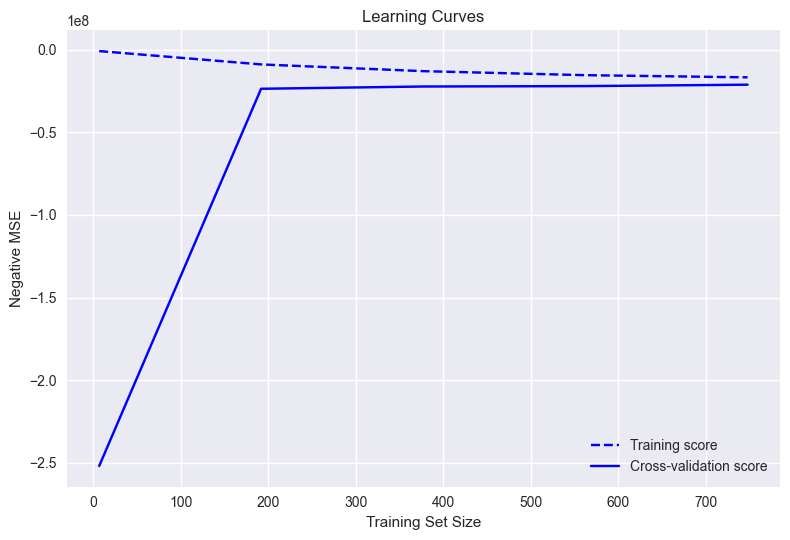

In [1002]:
# Call the function
plot_learning_curves(best_model, X_train, y_train)

<p>The model starts to converge from 200 training set size and the bias is low means we don't have underfit.
Also, the gap between training score and cross-validation score is small means variance is low (no overfit).</p>

# Summary

<p style="font-size: 15px">After training several models to predict charge values, we selected the best one based on R² and RMSE scores. XGBoost performed best after hyperparameter tuning. The model converged with a training set size of 200, and the most influential feature was smoking_yes.</p>